In [1]:
import numpy as np
import pandas as pd
import glob
import re
from collections import Counter
from tqdm import tqdm # to show progress bar of tasks
from sklearn.preprocessing import MinMaxScaler

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Sort all observables from file names

In [ ]:
def sorter(input_list):
    element_counts = Counter(input_list)
    single_occurrences = [element for element, count in element_counts.items() if count == 1]
    multiple_occurrences = [element for element, count in element_counts.items() if count > 1]
    result = np.sort(np.array(single_occurrences + multiple_occurrences))
    return result

unsorted_mass, unsorted_fov, unsorted_logD = [], [], []
files = glob.glob('/home/ankurk/Desktop/astero_stuff/eeps_1p2_to_5/eep_class/*')

for f in files:
    vals = re.findall(r'\d+', f.split('/')[-1]) 
    unsorted_mass.append(float(vals[2])/100)
    unsorted_fov.append(float(vals[3])/100)
    unsorted_logD.append(float(vals[4])/100)

mass = sorter(unsorted_mass)
fov = sorter(unsorted_fov)
logD = sorter(unsorted_logD)

#### create single large dataframe with all input and derived parameters 

In [ ]:
headers = ['star_age','star_mass','log_Teff','log_L','log_R','log_g','center_h1','center_he4','mass_conv_core','he_core_mass','he_core_radius','mass_bdy_core_overshooting','radius_bdy_core_overshooting','Asymptotic_dP_method_A','Asymptotic_dP_method_A.1','mass','fov','logD']
final_df = pd.DataFrame(columns=headers)

for m in tqdm(mass):
        for f in fov:
            for lD in logD:
                file_name = '/home/ankurk/Desktop/astero_stuff/eeps_1p2_to_5/eep_class/deo_Zini00140_MLT180_Mini0'+str(round(float(m*100)))+'_fov00'+str(f"{int(f * 100):03d}")+'_logDext'+str(f"{int(lD * 100):03d}")+'.eep'
                df = pd.read_csv(file_name,  delim_whitespace = True)
                df['mass'] = np.full(len(df['star_age']), m)
                df['fov'] = np.full(len(df['star_age']), f)
                df['logD'] = np.full(len(df['star_age']), lD)
                final_df = pd.concat([final_df, df], ignore_index=True)
                

#### minimization

In [3]:
df = pd.read_csv('/home/ankur/Desktop/Asteroseismology/mesa_modelling_task/concat_df.csv', sep = ',',  index_col=0)

/home/ankur/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 [Text(0, 0.5, 'star_age'),
  Text(0, 1.5, 'star_mass'),
  Text(0, 2.5, 'log_Teff'),
  Text(0, 3.5, 'log_L'),
  Text(0, 4.5, 'log_R'),
  Text(0, 5.5, 'log_g'),
  Text(0, 6.5, 'center_h1'),
  Text(0, 7.5, 'center_he4'),
  Text(0, 8.5, 'mass_conv_core'),
  Text(0, 9.5, 'he_core_mass'),
  Text(0, 10.5, 'he_core_radius'),
  Text(0, 11.5, 'mass_bdy_core_overshooting'),
  Text(0, 12.5, 'radius_bdy_core_overshooting'),
  Text(0, 13.5, 'Asymptotic_dP_method_A'),
  Text(0, 14.5, 'Asymptotic_dP_method_A.1'),
  Text(0, 15.5, 'mass'),
  Text(0, 16.5, 'fov'),
  Text(0, 17.5, 'logD')])

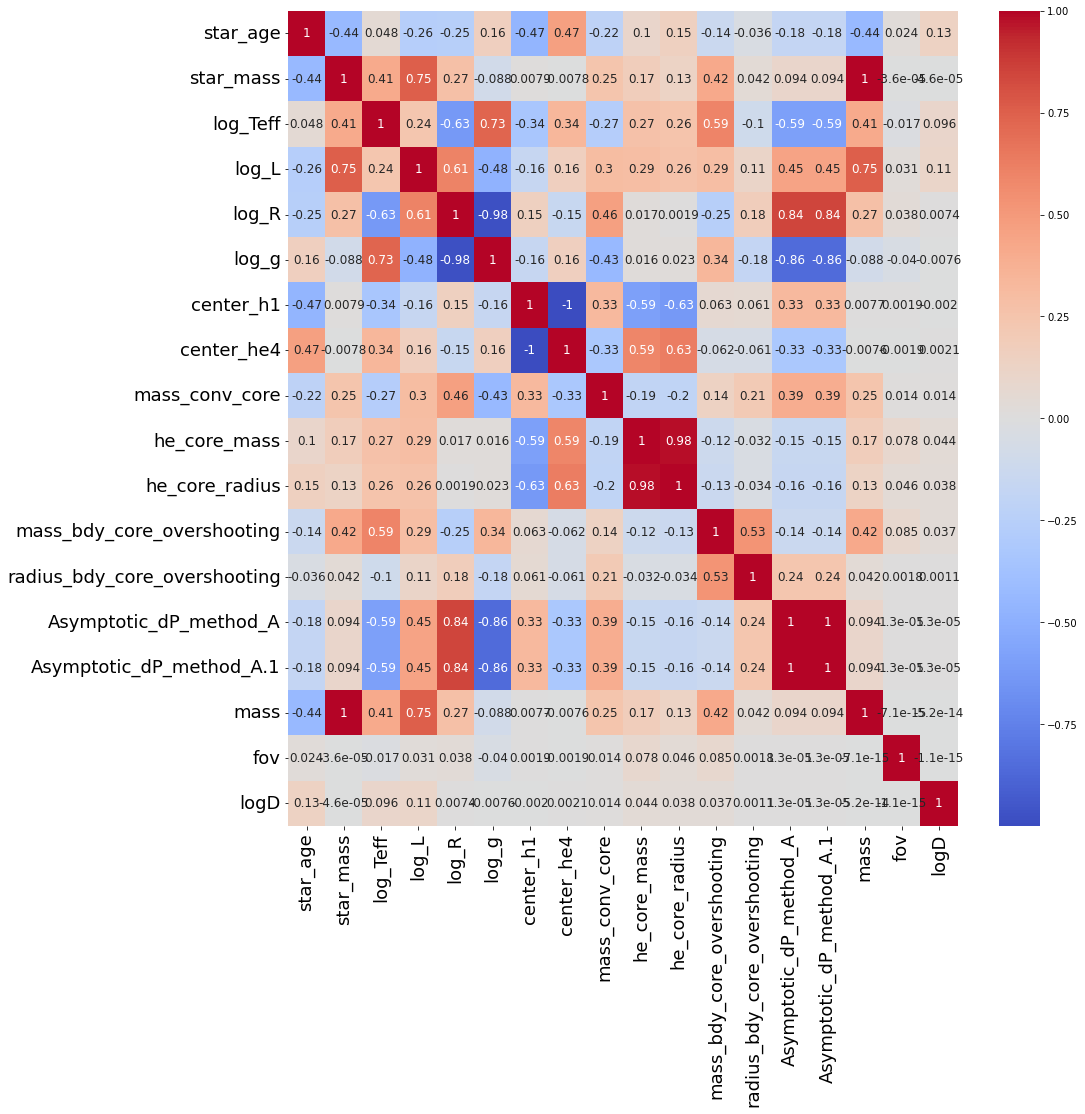

In [28]:
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 12})
plt.xticks(fontsize=18)  # Adjust the font size here
plt.yticks(fontsize=18)  

In [4]:
def scaler(array, obs, err):
        model_values = array 

        observed_value = obs
        observed_error_max = obs + err 
        observed_error_min = obs - err
        scaler = MinMaxScaler()
        scaled_model_values = scaler.fit_transform(np.array(model_values).reshape(-1, 1)).flatten()
        min_scaled_model = min(scaled_model_values)
        max_scaled_model = max(scaled_model_values)
        mapped_observed_value = min_scaled_model + (observed_value - min(model_values)) * (max_scaled_model - min_scaled_model) / (max(model_values) - min(model_values))
        mapped_max_observed_error_pi = min_scaled_model + (observed_error_max - min(model_values)) * (max_scaled_model - min_scaled_model) / (max(model_values) - min(model_values))
        mapped_min_observed_error_pi = min_scaled_model + (observed_error_min - min(model_values)) * (max_scaled_model - min_scaled_model) / (max(model_values) - min(model_values))
        return scaled_model_values, mapped_observed_value, (mapped_max_observed_error_pi - mapped_observed_value)/2

In [5]:
pi = 4900
pi_err = 500
teff = 7300
log_teff = np.log10(teff)
teff_err = 180
log_teff_err = (1/np.log(10))* (teff_err/teff)
log = 4.2
log_err = 0.3

In [6]:
df['scaled_pi'], pi_obs, pi_err = scaler(np.array(df['Asymptotic_dP_method_A'])*86400, pi, pi_err)
df['scaled_teff'], t_obs, t_err = scaler(np.array(df['log_Teff']), log_teff, log_teff_err)
df['scaled_logg'], g_obs, g_err = scaler(np.array(df['log_g']), log, log_err)

In [7]:
df = df[df['star_age']>1e8].reset_index()

In [8]:
age_df_pi, h1_df_pi, mass_df_pi, f_df_pi, lD_df_pi, core_df_pi= [], [], [], [], [], []


for i in tqdm(range(0, 1000)):
    pi = np.random.normal(pi_obs, pi_err)
    log_temp = np.random.normal(t_obs, t_err)    
    logg = np.random.normal(g_obs, g_err)

    del_pi0_pi = (np.array(df['scaled_pi']) -pi)**2
    #min_del_pi = min(del_pi0_pi)
    
    min_index_pi = np.argmin(del_pi0_pi)   
    age_df_pi.append(df['star_age'][min_index_pi])
    h1_df_pi.append(df['center_h1'][min_index_pi])
    mass_df_pi.append(df['mass'][min_index_pi])
    f_df_pi.append(df['fov'][min_index_pi])
    lD_df_pi.append(df['logD'][min_index_pi])
    core_df_pi.append(df['mass_conv_core'][min_index_pi])
    


100%|██████████| 1000/1000 [00:07<00:00, 141.68it/s]


In [63]:
age_df_teff, h1_df_teff, mass_df_teff, f_df_teff, lD_df_teff, core_df_teff, log_L, log_g, log_R = [], [], [], [], [], [], [], [], []

for i in tqdm(range(0, 1000)):
    pi = np.random.normal(pi_obs, pi_err)
    log_temp = np.random.normal(t_obs, t_err)    
    #logg = np.random.normal(g_obs, g_err)

    del_pi0_teff = ((np.array(df['scaled_pi']) -pi)/pi_err)**2 + ((np.array(df['scaled_teff'])-log_temp)/t_err)**2

    min_index_t = np.argmin(del_pi0_teff)   
    #age_df_teff.append(df['star_age'][min_index_t])
    #h1_df_teff.append(df['center_h1'][min_index_t])
    #mass_df_teff.append(df['mass'][min_index_t])
    #f_df_teff.append(df['fov'][min_index_t])
    #lD_df_teff.append(df['logD'][min_index_t])
    #core_df_teff.append(df['mass_conv_core'][min_index_t])
    log_L.append(df['log_L'][min_index_t])
    log_g.append(df['log_g'][min_index_t])
    log_R.append(df['log_R'][min_index_t])
    


 95%|█████████▍| 947/1000 [00:16<00:00, 55.78it/s]

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
from scipy.optimize import curve_fit

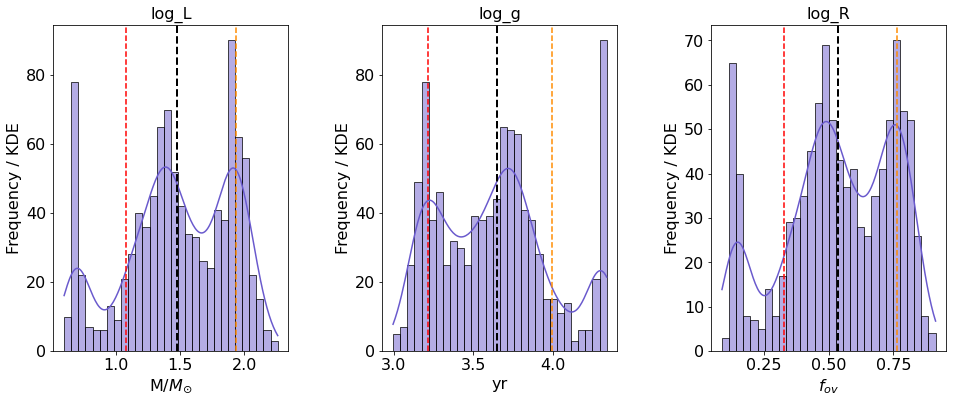

In [62]:
data_list = [np.array(log_L), np.array(log_g), np.array(log_R)]

# Define colors for KDE lines
kde_colors = ['red', 'green', 'blue']

# Define specific titles
titles = ['log_L', 'log_g', 'log_R']
values = ['M/$M_{\odot}$', 'yr', '$f_{ov}$']
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=[16, 6])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i, ax in enumerate(axes.flatten()):
    data = data_list[i]
    
    sns.histplot(data, bins=30, kde=True, ax=ax, color='slateblue', alpha = 0.5)
    
    # Fit a KDE (Kernel Density Estimation)
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)
    median = np.median(data)
    # Calculate percentiles using KDE
    kde_percentiles = stats.mstats.mquantiles(data, prob=[0.16, 0.84], alphap=0.5, betap=0.5)
    
    # Plot KDE line with different color
    #ax.plot(x, kde(x), color=kde_colors[i], label='_nolegend_')
    
    # Plot KDE-based 16th and 84th percentile lines
    ax.axvline(x=kde_percentiles[0], color='red', linestyle='dashed', label='KDE 16th Percentile')
    ax.axvline(x=kde_percentiles[1], color='darkorange', linestyle='dashed', label='KDE 84th Percentile')
    ax.axvline(x=median, color='black', linestyle='dashed', label='Median', linewidth=2)
    ax.set_title(titles[i], fontsize=16)  # Set title with larger font size
    ax.set_xlabel(values[i], fontsize=16)    # Set x-label with larger font size
    ax.set_ylabel('Frequency / KDE', fontsize=16)  # Set y-label with larger font size
    ax.tick_params(axis='both', which='major', labelsize=16)  # Set tick label size

    #ax.legend(fontsize=16) 

In [11]:
age_df_g, h1_df_g, mass_df_g, f_df_g, lD_df_g, core_df_g = [], [], [], [], [], []
for i in tqdm(range(0, 1000)):
    pi = np.random.normal(pi_obs, pi_err)
    log_temp = np.random.normal(log_teff, log_teff_err)    
    logg = np.random.normal(log, log_err)

    del_pi0_g =  (np.array(df['log_Teff'])-log_temp)**2 + (np.array(df['log_g'])-logg)**2

    min_index_g = np.argmin(del_pi0_g)   
    age_df_g.append(df['star_age'][min_index_g])
    h1_df_g.append(df['center_h1'][min_index_g])
    mass_df_g.append(df['mass'][min_index_g])
    f_df_g.append(df['fov'][min_index_g])
    lD_df_g.append(df['logD'][min_index_g])
    core_df_g.append(df['mass_conv_core'][min_index_g])
    

100%|██████████| 1000/1000 [00:12<00:00, 81.48it/s]


<AxesSubplot:ylabel='Count'>

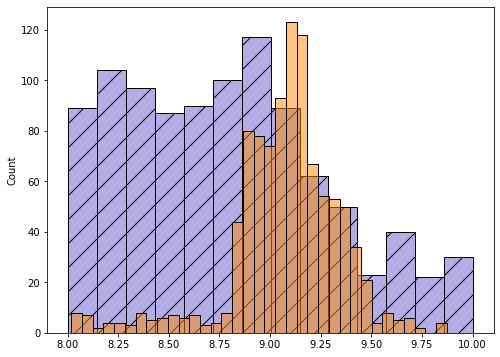

In [11]:

plt.figure(figsize = [8,6])
sns.histplot( np.log10(age_df_pi), color = 'slateblue', alpha = 0.5, hatch = '/')
sns.histplot( np.log10(age_df_teff), color = 'darkorange', alpha = 0.5)
#plt.xlim(0, 4e9)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
from scipy.optimize import curve_fit

In [44]:
data = np.array(h1_df_teff)

# Value threshold
threshold = 0.05

# Create a boolean mask based on the condition
mask = data >= threshold

# Apply the mask to drop values that satisfy the condition
filtered_data = data[mask]

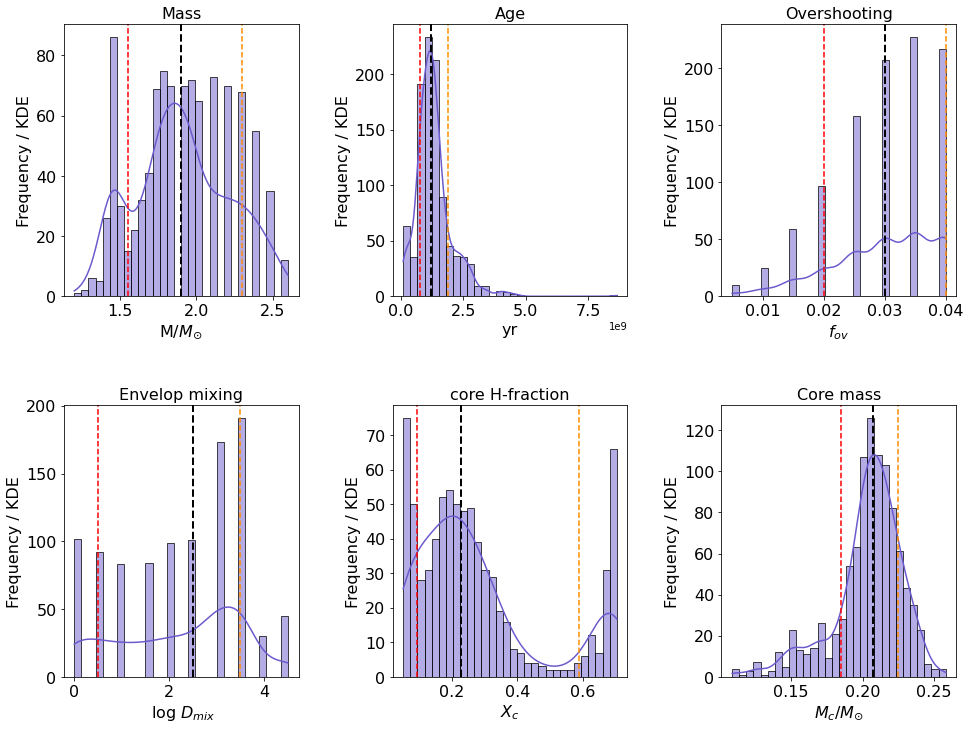

In [54]:

# Generate example data (replace with your data)
data_list = [np.array(mass_df_teff), np.array(age_df_teff), np.array(f_df_teff)*0.01, 
             np.array(lD_df_teff), filtered_data, np.array(core_df_teff)]

# Define colors for KDE lines
kde_colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']

# Define specific titles
titles = ['Mass', 'Age', 'Overshooting', 'Envelop mixing', 'core H-fraction', 'Core mass']
values = ['M/$M_{\odot}$', 'yr', '$f_{ov}$', ' log $D_{mix}$', '$X_c$', '${M_c}/{M_{\odot}}$']
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=[16, 12])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i, ax in enumerate(axes.flatten()):
    data = data_list[i]
    
    sns.histplot(data, bins=30, kde=True, ax=ax, color='slateblue', alpha = 0.5)
    
    # Fit a KDE (Kernel Density Estimation)
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)
    median = np.median(data)
    # Calculate percentiles using KDE
    kde_percentiles = stats.mstats.mquantiles(data, prob=[0.16, 0.84], alphap=0.5, betap=0.5)
    
    # Plot KDE line with different color
    #ax.plot(x, kde(x), color=kde_colors[i], label='_nolegend_')
    
    # Plot KDE-based 16th and 84th percentile lines
    ax.axvline(x=kde_percentiles[0], color='red', linestyle='dashed', label='KDE 16th Percentile')
    ax.axvline(x=kde_percentiles[1], color='darkorange', linestyle='dashed', label='KDE 84th Percentile')
    ax.axvline(x=median, color='black', linestyle='dashed', label='Median', linewidth=2)
    ax.set_title(titles[i], fontsize=16)  # Set title with larger font size
    ax.set_xlabel(values[i], fontsize=16)    # Set x-label with larger font size
    ax.set_ylabel('Frequency / KDE', fontsize=16)  # Set y-label with larger font size
    ax.tick_params(axis='both', which='major', labelsize=16)  # Set tick label size

    #ax.legend(fontsize=16) 

plt.savefig('error.png')


In [55]:
data_list = [np.array(mass_df_teff), np.array(age_df_teff), np.array(f_df_teff), 
             np.array(lD_df_teff), np.array(core_df_teff), filtered_data]

# Define specific titles
titles = ['Mass', 'Age', 'Overshooting', 'Envelope Mixing', 'Core Mass', 'h_frac']

for i, data in enumerate(data_list):
    # Calculate percentiles using KDE
    kde_percentiles = stats.mstats.mquantiles(data, prob=[0.16, 0.84], alphap=0.5, betap=0.5)
    
    # Calculate median
    median = np.median(data)
    
    print(f"Statistics for {titles[i]}:")
    print(f"16th Percentile: {kde_percentiles[0]:.2f}")
    print(f"84th Percentile: {kde_percentiles[1]:.2f}")
    print(f"Median: {median:.2f}")
    print("=" * 30)

Statistics for Mass:
16th Percentile: 1.55
84th Percentile: 2.30
Median: 1.90
Statistics for Age:
16th Percentile: 762819476.36
84th Percentile: 1903403721.89
Median: 1215224853.58
Statistics for Overshooting:
16th Percentile: 2.00
84th Percentile: 4.00
Median: 3.00
Statistics for Envelope Mixing:
16th Percentile: 0.50
84th Percentile: 3.50
Median: 2.50
Statistics for Core Mass:
16th Percentile: 0.18
84th Percentile: 0.22
Median: 0.21
Statistics for h_frac:
16th Percentile: 0.09
84th Percentile: 0.59
Median: 0.23


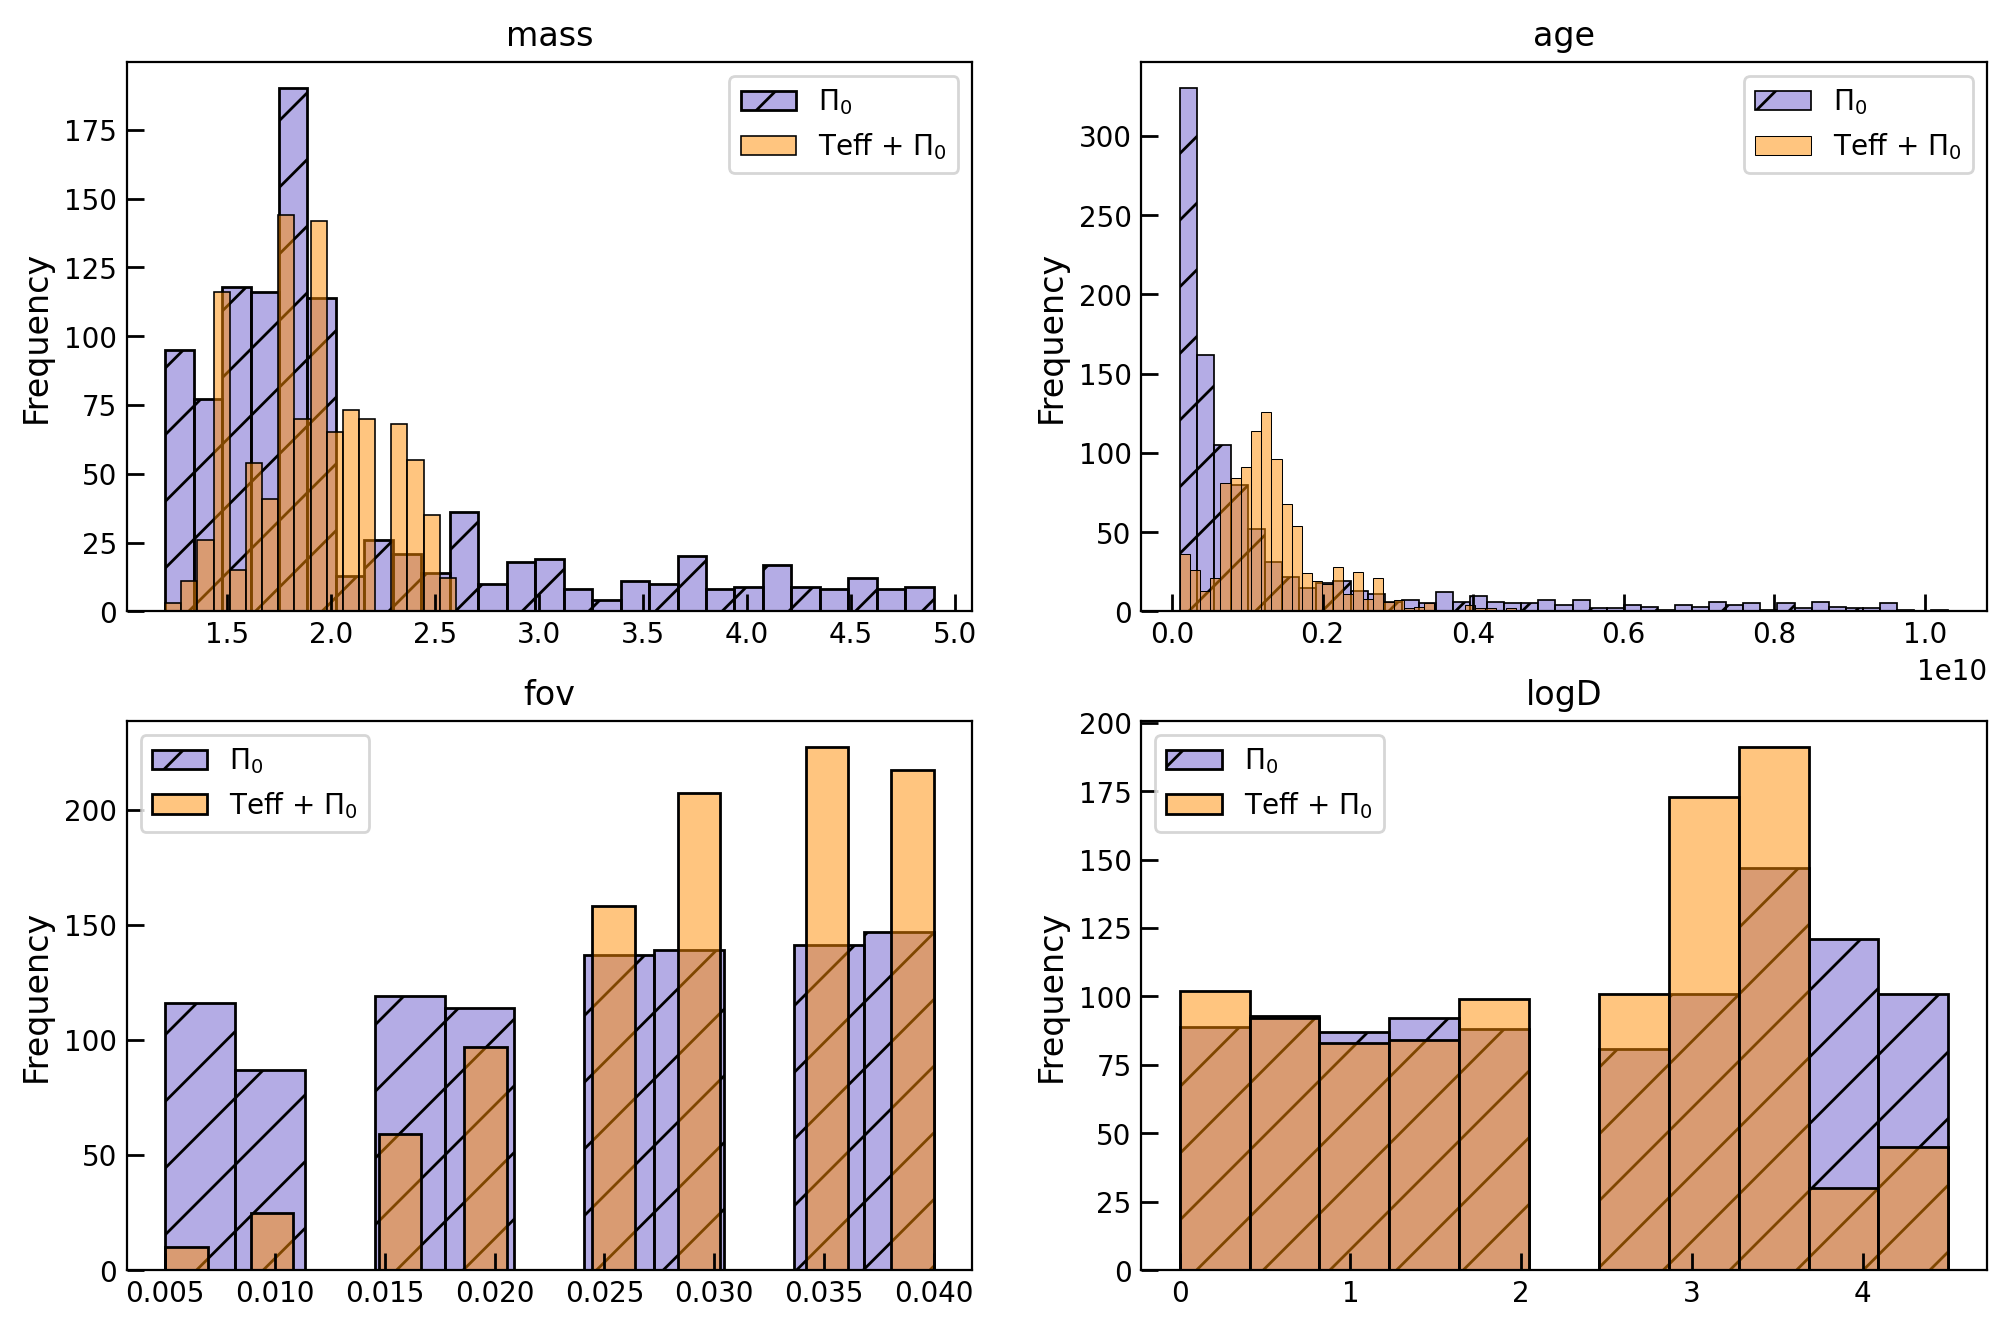

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi = 200)



# Set larger tick parameters, label sizes, and title sizes
for ax in axs.flat:
    ax.tick_params(axis='both', which='both', labelsize=10, direction='in', length=6, width=1)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    ax.title.set_size(14)

# Plot data and customize
#sns.histplot(data=mass_df_g, ax=axs[0, 0], color='chartreuse', alpha=0.5, label='Teff + logg', bins = 20)
sns.histplot(data=mass_df_pi, ax=axs[0, 0], color='slateblue', alpha=0.5, hatch='/', label='$\Pi_0$')
sns.histplot(data=mass_df_teff, ax=axs[0, 0], color='darkorange', alpha=0.5, label='Teff + $\Pi_0$')

axs[0, 0].set_title('mass')
#axs[0, 0].set_xscale('log')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

#sns.histplot(data=age_df_g, ax=axs[0, 1], color='chartreuse', alpha=0.5, label='Teff + logg')
sns.histplot(data=age_df_pi, ax=axs[0, 1], color='slateblue', hatch='/', alpha=0.5, label='$\Pi_0$')
sns.histplot(data=age_df_teff, ax=axs[0, 1], color='darkorange', alpha=0.5, label='Teff + $\Pi_0$')
axs[0, 1].set_title('age')
#axs[0, 1].set_xscale('log')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()


#sns.histplot(data=f_df_g, ax=axs[1, 0], color='chartreuse', alpha=0.5, label='Teff + logg')
sns.histplot(data=np.array(f_df_pi)*0.01, ax=axs[1, 0], color='slateblue', hatch='/', alpha=0.5, label='$\Pi_0$')
sns.histplot(data=np.array(f_df_teff)*0.01, ax=axs[1, 0], color='darkorange', alpha=0.5, label='Teff + $\Pi_0$')
axs[1, 0].set_title('fov')
#axs[1, 0].set_xlabel('FOV')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

#sns.histplot(data=lD_df_g, ax=axs[1, 1], color='chartreuse', alpha=0.5, label='Teff + logg')
sns.histplot(data=lD_df_pi, ax=axs[1, 1], color='slateblue', hatch='/', alpha=0.5, label='$\Pi_0$')
sns.histplot(data=lD_df_teff, ax=axs[1, 1], color='darkorange', alpha=0.5, label='Teff + $\Pi_0$')
axs[1, 1].set_title('logD')
#axs[1, 1].set_xlabel('logD')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()
plt.savefig('astero.png')

In [20]:

plt.figure(figsize = [8,6])
sns.histplot(data=lD_df_teff, ax=axs[1, 1], color = 'darkorange')

<Axes: title={'center': 'logD'}, ylabel='Count'>

<Figure size 800x600 with 0 Axes>

In [ ]:
import pandas as pd

# First table data
data1 = {
    'frq': [1.2875983513291, 1.19875007615425, 1.11578988079706, 0.171817254169226,
            0.0888493680799868, 1.02694506882428, 2.40339149586722, 1.25495718237393,
            0.0712054328233055, 1.35880174037112, 2.48635754098847, 1.37644227831254,
            2.57518755108862, 2.31454776111463, 1.45942182076379, 0.0829842035004479,
            2.4745914480682, 1.18698270440956, 0.94399340501792],
    'amp': [0.0340529447932681, 0.0222939612827823, 0.0230172747993133, 0.00972613691333438,
            0.00828678070560637, 0.00610759688318292, 0.00540638979034529, 0.00523492430257203,
            0.00518595568097157, 0.00463544137732753, 0.00473938688968533, 0.00459513037742242,
            0.00431794083967401, 0.00390928233050472, 0.00352019015248871, 0.00361850982430796,
            0.00308698236399348, 0.00375270540874338, 0.00323058563423624],
    'phase': [0.882085748483787, 0.609573849862528, 0.0805496897969643, 0.196429900129644,
              0.17097503109216, 0.447896451227932, 0.0849181052698295, 0.528931712492333,
              0.02542362882223, 0.294904113575921, 0.285206753536305, 0.670037918906822,
              0.603348238367053, 0.503714637273608, 0.0656114185707182, 0.0831202352972454,
              0.672719961707909, 0.0414258255448733, 0.191207440624456]
}

# Second table data
data2 = {
    'Freq. sigma': [3.748096808e-07, 8.348903378e-07, 1.34066856e-06, 5.20157937e-06,
                    0.001790350596, 6.760966185e-06, 0.0179211411, 0.002680083853,
                    7.205547217e-06, 4.708770466e-06, 8.773833524e-06, 4.060024398e-06,
                    7.692425933e-06, 4.049273988, 0.0006718441231, 0.01564288526,
                    8.496100083e-06, 4.803280458e-06, 5.963623345e-06],
    'Ampl. sigma': [6.596382631e-05, 5.01900054e-05, 7.67988457e-05, 0.0001191447651,
                    0.003211268692, 8.133604983e-05, 0.0027218653, 0.001986041892,
                    0.0001260741582, 5.659514559e-05, 7.384321787e-05, 0.0001206494248,
                    3.730477665e-05, 0.001497545108, 0.001270870634, 0.001699295017,
                    0.0001273341446, 0.0001188941663, 6.933929215e-05],
    'Pha. sigma': [0.0003725815714, 0.000957098763, 0.0004243754369, 0.0006480110669,
                   0.01829899359, 0.00252700592, 0.2664359549, 0.2001290052,
                   0.002012924815, 0.003518601371, 0.002021235729, 0.001888251467,
                   0.002994331292, 0.003397170929, 0.004963995575, 0.2108695178,
                   0.003698433703, 0.004888147437, 0.002648051958]
}

# Create DataFrames
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Merge DataFrames
merged_df = pd.concat([df1, df2], axis=1)

# Convert DataFrame to LaTeX table
latex_table = merged_df.to_latex(index=False)

# Display LaTeX table
print(latex_table)